In [ ]:
import numpy as np
import torch
import torch.optim as optim
from torch.distributions.bernoulli import Bernoulli
from utils import *

from causalml.inference.meta import BaseDRRegressor
from sklearn.linear_model import LinearRegression

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns;sns.set_theme()

import gpytorch
from gpytorch.models import ApproximateGP
from gpytorch.variational import VariationalStrategy, CholeskyVariationalDistribution
from gpytorch.likelihoods import SoftmaxLikelihood
from gpytorch.mlls import VariationalELBO


In [17]:
torch.set_default_dtype(torch.float32)
torch.set_default_device("cuda")

torch.manual_seed(1)

dim_v = 20
card_u = 5
beta = torch.tensor(list(np.linspace(-5, 5, card_u)) + list(np.random.normal(0, 1, size = (dim_v,))), dtype=torch.float32).view(-1, 1)
trans = torch.rand((dim_v, card_u), dtype=torch.float32)

H = 30
num_epoch = 300
len_seq = 100

T = 100
n = 3000
n_eval = 10000
repeat_num = 5

# fix samples for policy eval 
u_eval, v_eval = x_generate(n_eval, dim_v, trans, seed=0)

# generate sequential data (before manipulation)
seed_list = range(10)
dataset = {}
for s in seed_list:
    dataset[s] = [x_generate(n, dim_v, trans, seed=s) for i in range(T)]

In [18]:
class MulticlassGPModel(ApproximateGP):
    def __init__(self, num_features = card_u, num_classes = card_u):
        variational_distribution = CholeskyVariationalDistribution(num_inducing_points=50)
        variational_strategy = VariationalStrategy(self, torch.randn(50, num_features), variational_distribution, learn_inducing_locations=True)
        super(MulticlassGPModel, self).__init__(variational_strategy)
        self.mean_module = gpytorch.means.ConstantMean(batch_shape=torch.Size([num_classes]))
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel(batch_shape=torch.Size([num_classes])), batch_shape=torch.Size([num_classes]))

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

In [ ]:
mani_u_list_mm = []


def StrategicGD(seed, dim_v, card_u, beta, H, len_seq, num_epoch, T, n, n_eval, lr_pi = 0.01, lr_prob = 0.01, cost_coef = 0.05):
    print(seed)
    torch.set_default_dtype(torch.float32) 
    torch.set_default_device("cuda")
    
    torch.manual_seed(seed)
    np.random.seed(seed)
    torch.cuda.manual_seed_all(seed)

    num_hiddens_pi = 2 * (dim_v + card_u)
    model_pi = allocation_policy(dim_v + card_u, num_hiddens_pi)
    cate_learner = BaseDRRegressor(learner=LinearRegression(), treatment_effect_learner=LinearRegression())
    
    t = 0
    seq_revenue = []
    seq_loss = []
    seq_val = []
    seq_inputs = []
    seq_category = []
    seq_x = []
    seq_z = []
    seq_y = []
    seq_pi = []
    
    optimizer_pi = optim.Adam(model_pi.parameters(), lr=lr_pi)    
    for t in range(H):
        u, v = dataset[seed][t]
        inputs, u_category, u_shift = manipulation(u, v, n, card_u, model_pi, c=cost_coef)        
        mani_u_list_mm.append(u_shift)
            
        # training of allocation policy
        x = torch.cat((u_shift, v), dim=1)
        pi = model_pi(x)
        z = Bernoulli(probs=pi).sample()
        y = y_generate(x, z, n, beta, seed=seed)        
        inputs = inputs[:,-card_u:]
        
        seq_inputs.append(inputs.detach())
        seq_category.append(u_category)
        seq_x.append(x)
        seq_z.append(z)
        seq_y.append(y)
        seq_pi.append(pi)

        cate_fit(seq_x, seq_y, seq_z, seq_pi, cate_learner)
        tau = cate_predict(x, pi, cate_learner).cuda()    
        revenue = - torch.mean(pi * tau.detach())

        optimizer_pi.zero_grad()
        revenue.backward()
        optimizer_pi.step()

        # evaluation of allocation policy    
        _, _, u_eval_shift = manipulation(u_eval, v_eval, n_eval, card_u, model_pi, c=cost_coef)
        x_eval = torch.cat((u_eval_shift, v_eval), dim=1)
        pi_eval = model_pi(x_eval)
        tau_eval = x_eval @ beta
        value = torch.mean(pi_eval * tau_eval)
        seq_revenue.append(value.item())

    # warmup ends
    # training of the shifted distribution
    stacked_inputs = torch.cat(seq_inputs, dim=0)
    stacked_category = torch.cat(seq_category, dim=0)

    random_indices = torch.randperm(stacked_inputs.shape[0])
    stacked_inputs = stacked_inputs[random_indices]
    stacked_category = stacked_category[random_indices]

    n_sample = int(stacked_inputs.shape[0] * 0.8)

    train_inputs = stacked_inputs[0:n_sample, :]
    train_category = stacked_category[0:n_sample, :]

    
    model_prob = MulticlassGPModel()
    likelihood = SoftmaxLikelihood(num_classes=card_u, mixing_weights=None)
    mll = VariationalELBO(likelihood, model_prob, num_data=n_sample)
    optimizer_prob = torch.optim.Adam([{'params': model_prob.parameters()}, {'params': likelihood.parameters()}], lr=lr_prob)

    
    for epoch in range(num_epoch):
        output = model_prob(train_inputs)
        loss = -mll(output, train_category.view(-1))        
        optimizer_prob.zero_grad()
        loss.backward()
        optimizer_prob.step()        
        seq_loss.append(loss.item())
        

    print("Final Training Loss: %.3f"%loss.item())
    print("Epoch: %d"%epoch)
    
    optimizer_pi = optim.Adagrad(model_pi.parameters(), lr=lr_pi)     
    
    
    while True:
        t = t + 1
        u, v = dataset[seed][t]
        inputs, u_category, u_shift = manipulation(u, v, n, card_u, model_pi, c=cost_coef)  
        inputs = inputs[:,-card_u:]      
        # record u after manipulation
        mani_u_list_mm.append(u_shift)                
        seq_inputs.append(inputs.detach())
        seq_category.append(u_category)

        if len(seq_inputs) > len_seq:
            seq_inputs.pop(0)
            seq_category.pop(0)

        # train model pi
        x = torch.cat((u_shift, v), dim=1)        
        z = Bernoulli(probs=pi).sample()
        y = y_generate(x, z, n, beta, seed=seed)
        seq_x.append(x)
        seq_z.append(z)
        seq_y.append(y)
        pi = model_pi(x)  
        seq_pi.append(pi) 
        
        preds = likelihood(model_prob(inputs))
        predicted_probs = preds.probs.mean(dim=0)
        log_prob = nn.LogSoftmax(dim=1)(predicted_probs)[torch.arange(n), u_category.view(-1)]              
        tau = cate_predict(x, pi, cate_learner).cuda()     
        
        revenue = - torch.mean(pi * tau) -  torch.mean(pi.detach() * tau * log_prob)            
        optimizer_pi.zero_grad()
        revenue.backward(retain_graph=True)        
        optimizer_pi.step()

        # evaluation of allocation policy
        _, _, u_eval_shift = manipulation(u_eval, v_eval, n_eval, card_u, model_pi, c=cost_coef)
        x_eval = torch.cat((u_eval_shift, v_eval), dim=1)
        pi_eval = model_pi(x_eval)
        tau_eval = x_eval @ beta
        value = torch.mean(pi_eval * tau_eval)
        seq_revenue.append(value.item())

        if t >= T - 1:
            break
            
    plt.figure(figsize=(16,6))
    plt.subplot(1, 2, 1)
    plt.plot(seq_revenue)

    plt.subplot(1, 2, 2)
    plt.plot(seq_loss, label='train loss')
    plt.plot(seq_val, label='val loss')
    plt.legend()
    plt.show()
    
    if seed == 0:
        torch.save(model_pi, "models/model_pi_gp_cc_{}.pkl".format(cost_coef))
        torch.save(model_prob, "models/model_prob_gp_cc_{}.pkl".format(cost_coef))        

    return seq_revenue


0.1
0
Final Training Loss: 1.197
Epoch: 299


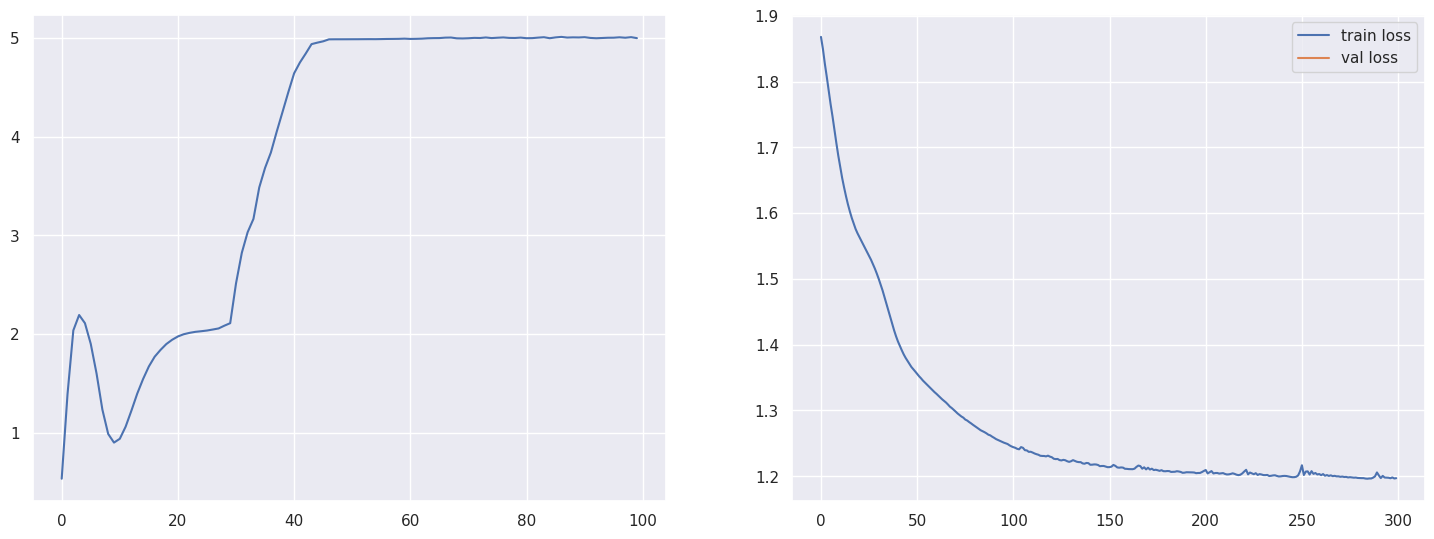

1
Final Training Loss: 1.276
Epoch: 299


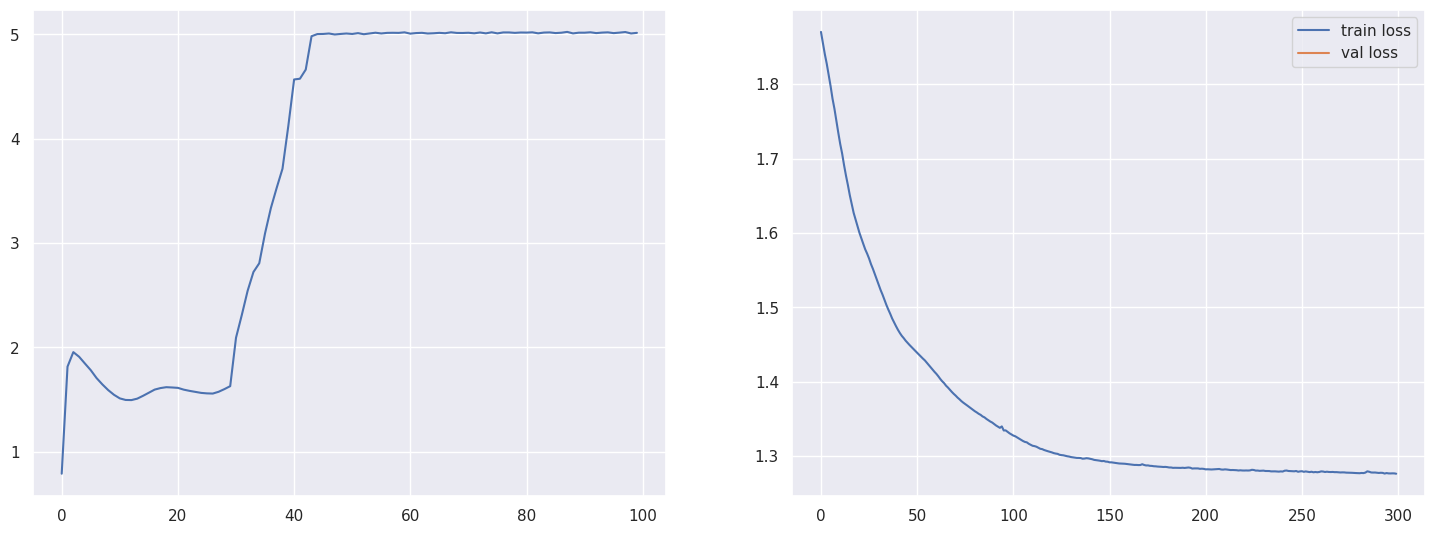

2
Final Training Loss: 1.189
Epoch: 299


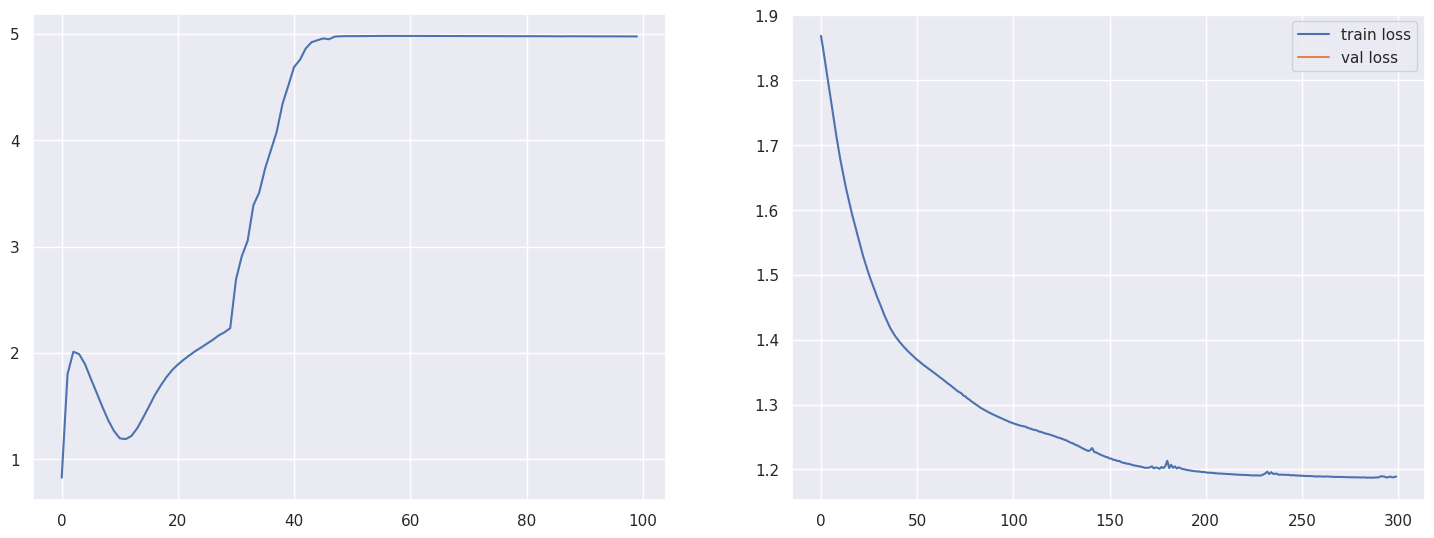

3
Final Training Loss: 1.226
Epoch: 299


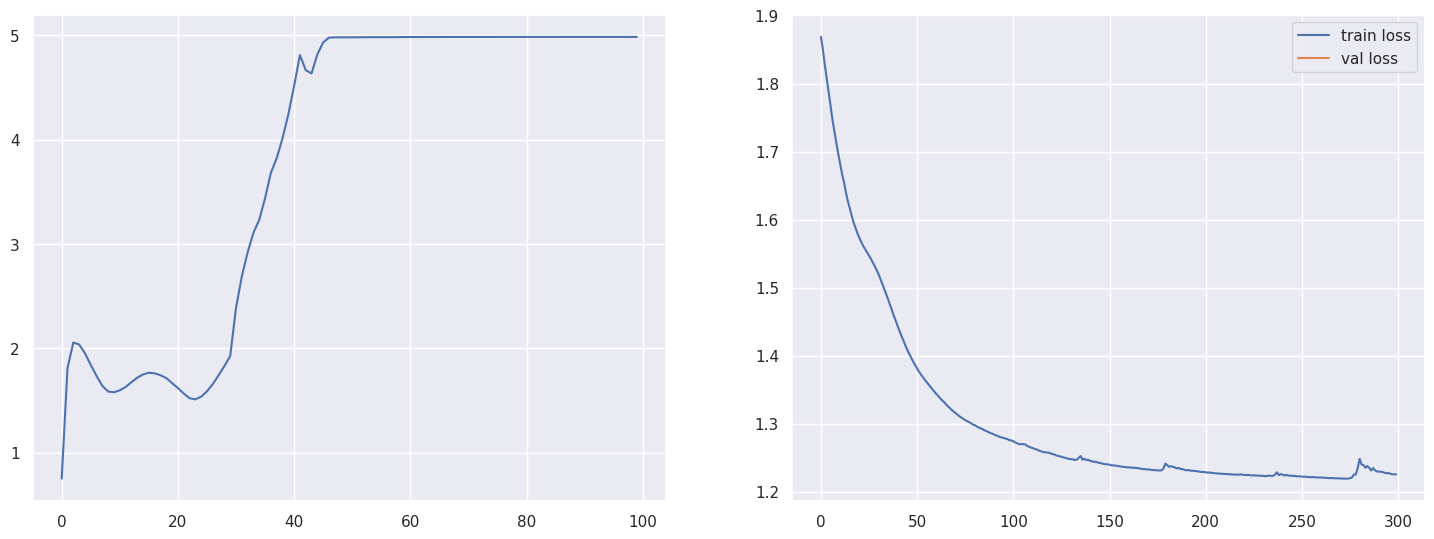

4
Final Training Loss: 1.281
Epoch: 299


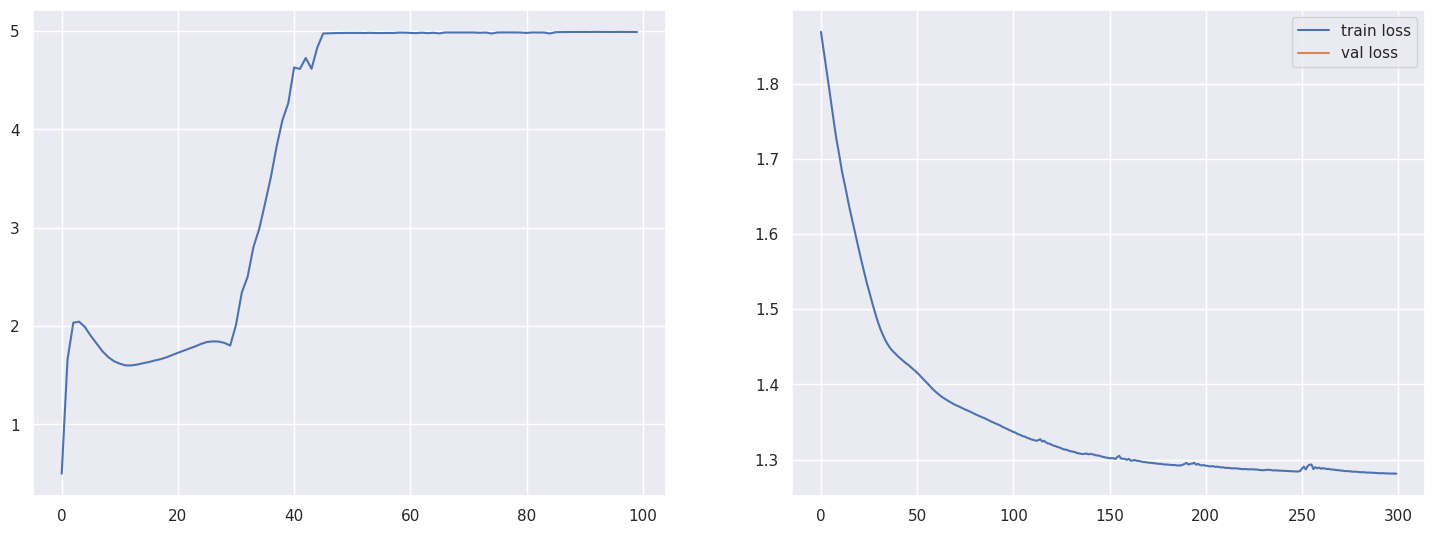

5
Final Training Loss: 1.263
Epoch: 299


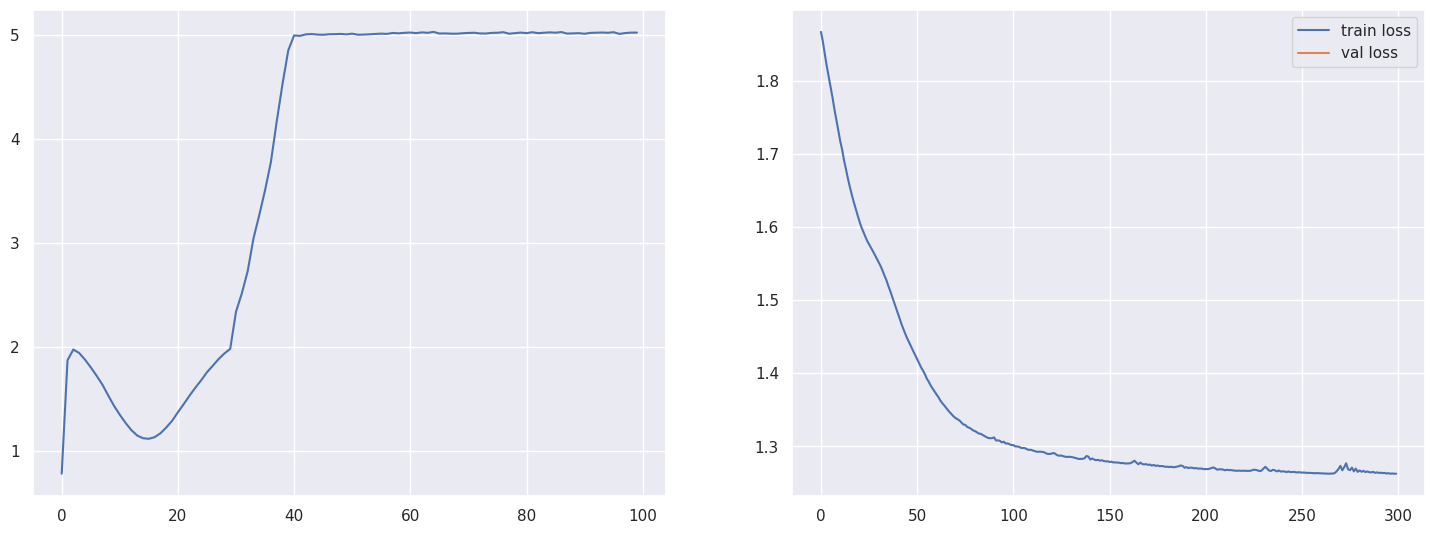

6
Final Training Loss: 1.249
Epoch: 299


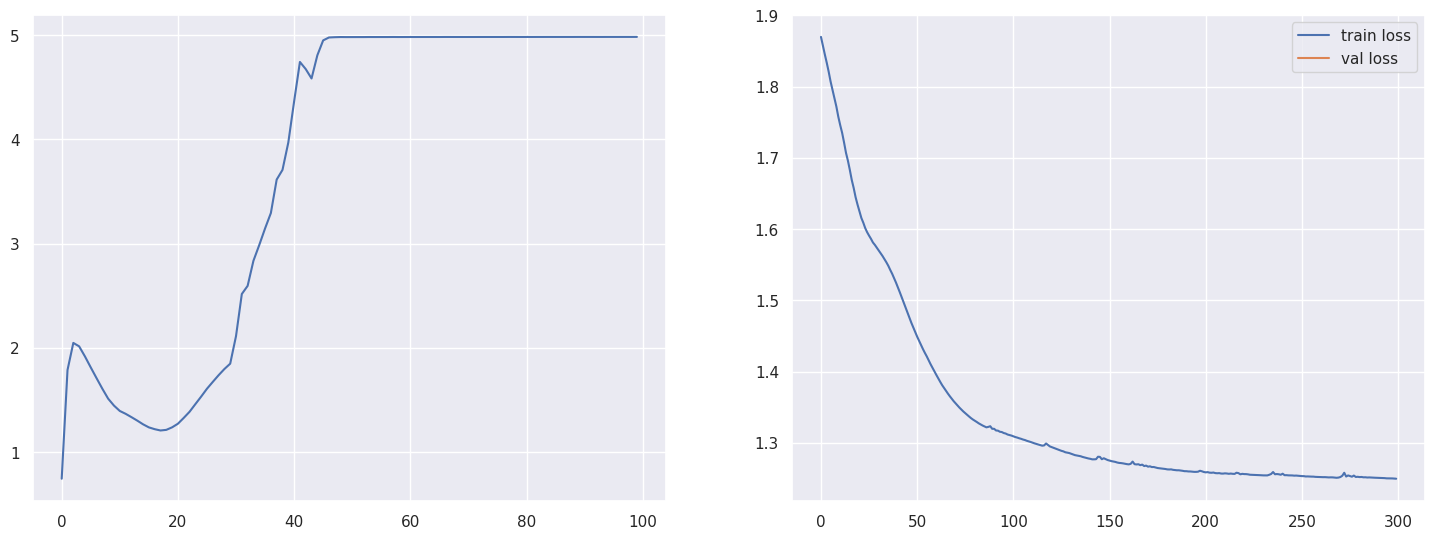

7
Final Training Loss: 1.252
Epoch: 299


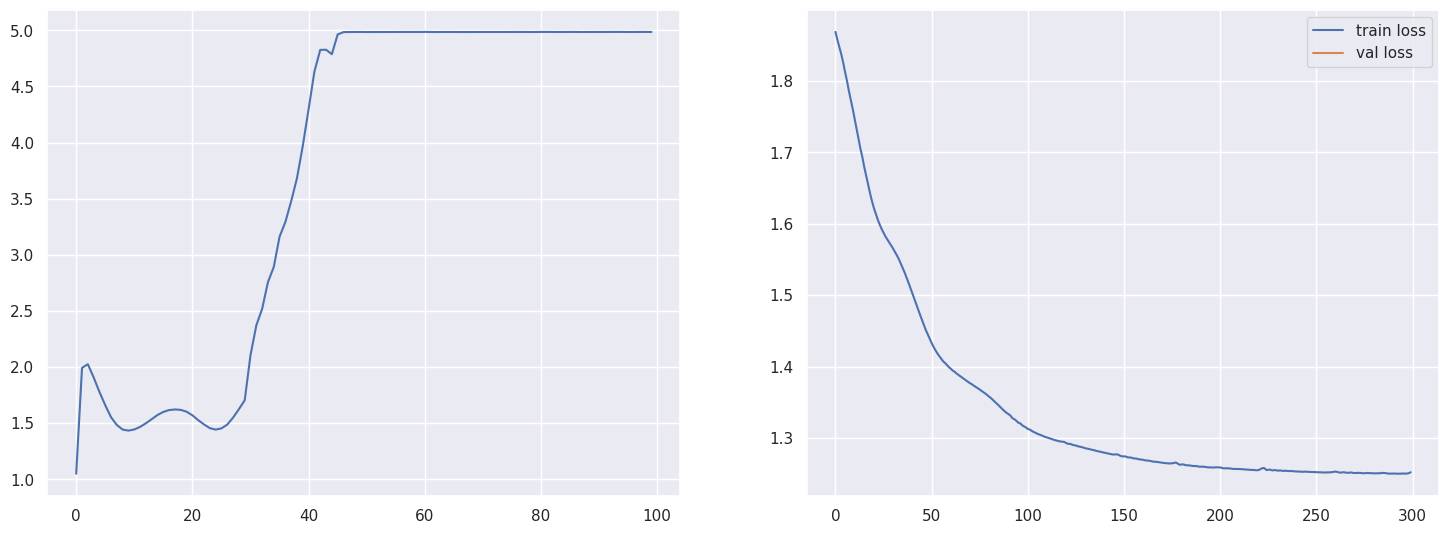

8
Final Training Loss: 1.233
Epoch: 299


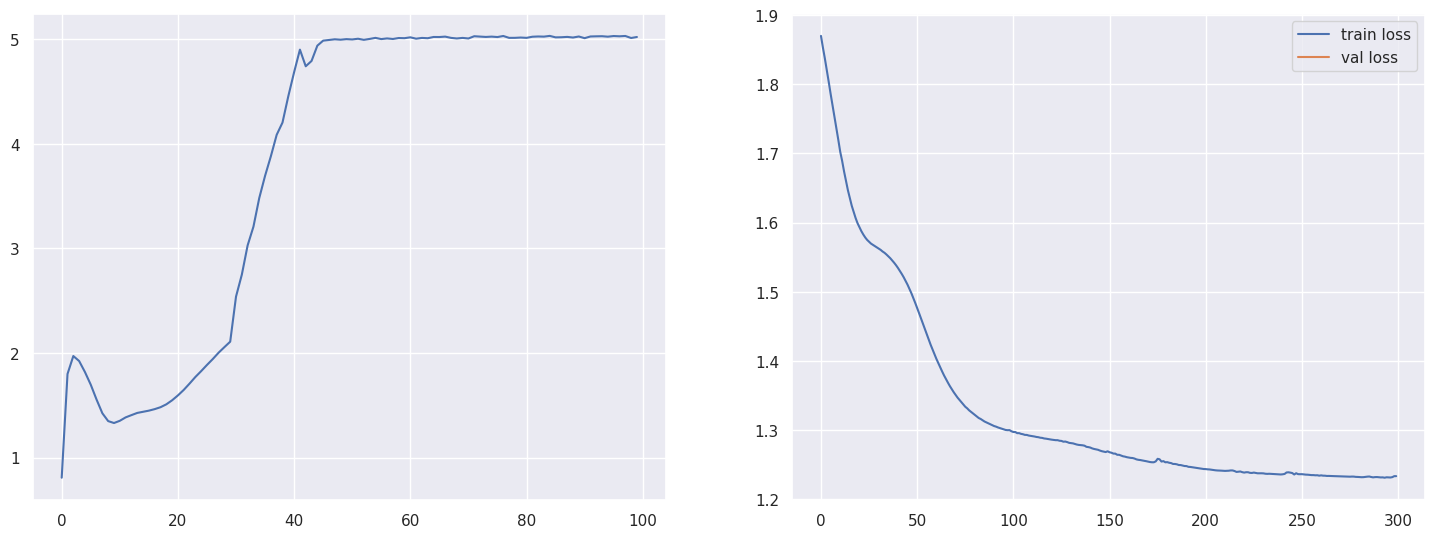

9
Final Training Loss: 1.262
Epoch: 299


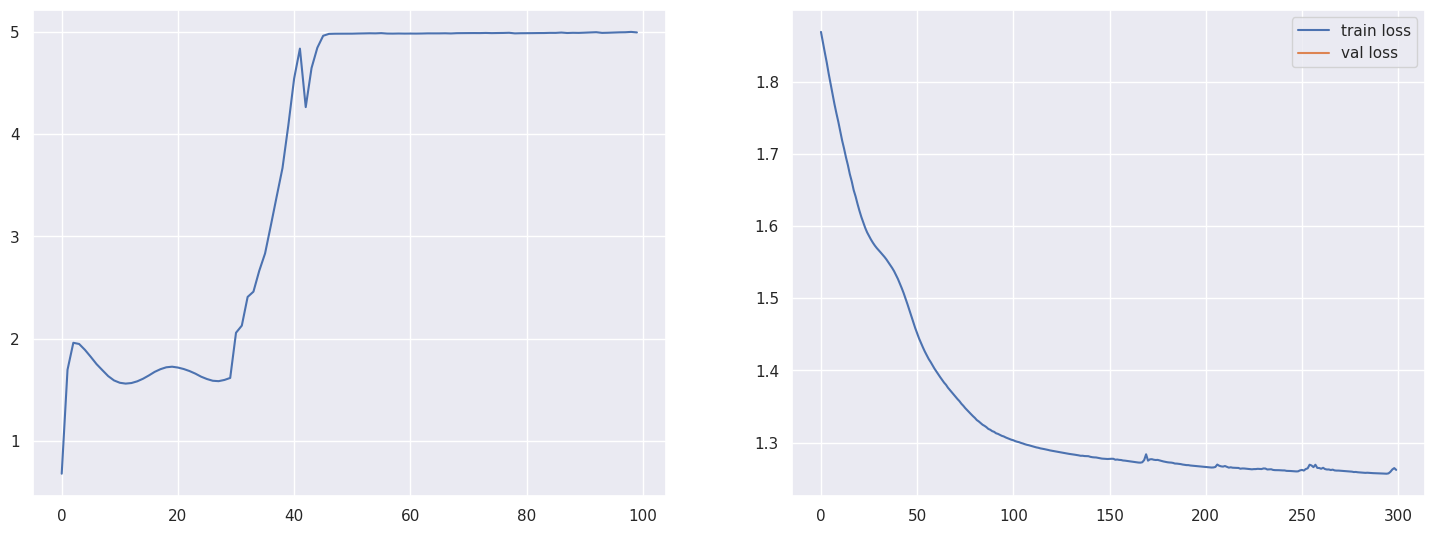

0.05
0
Final Training Loss: 1.219
Epoch: 299


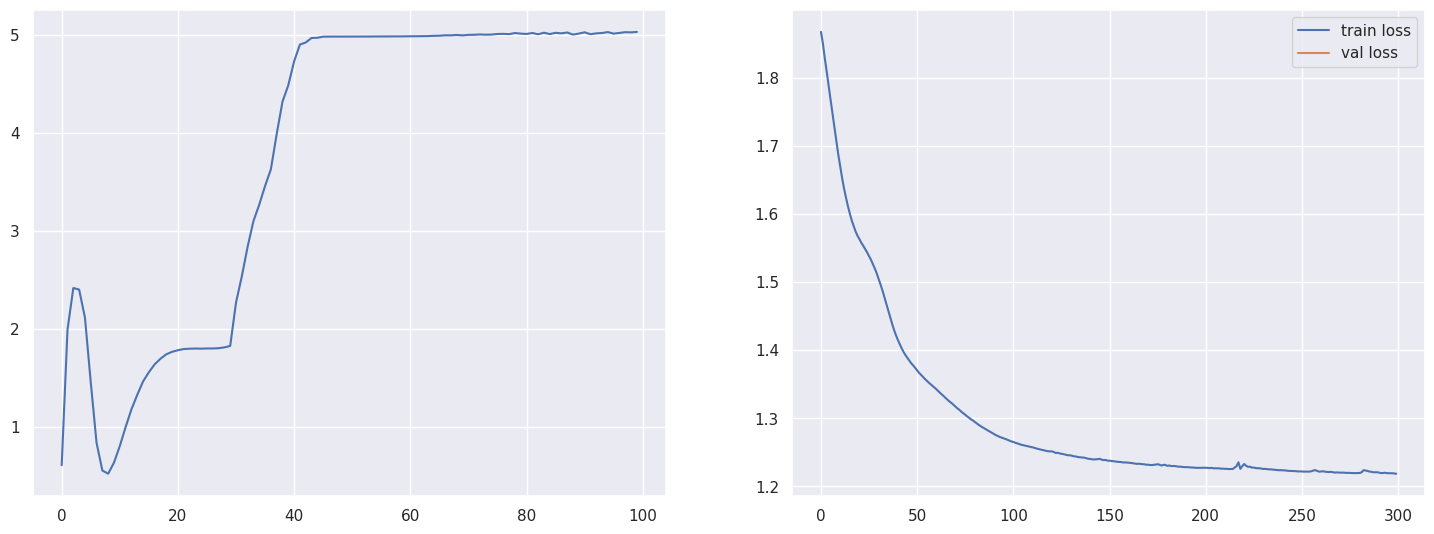

1
Final Training Loss: 1.269
Epoch: 299


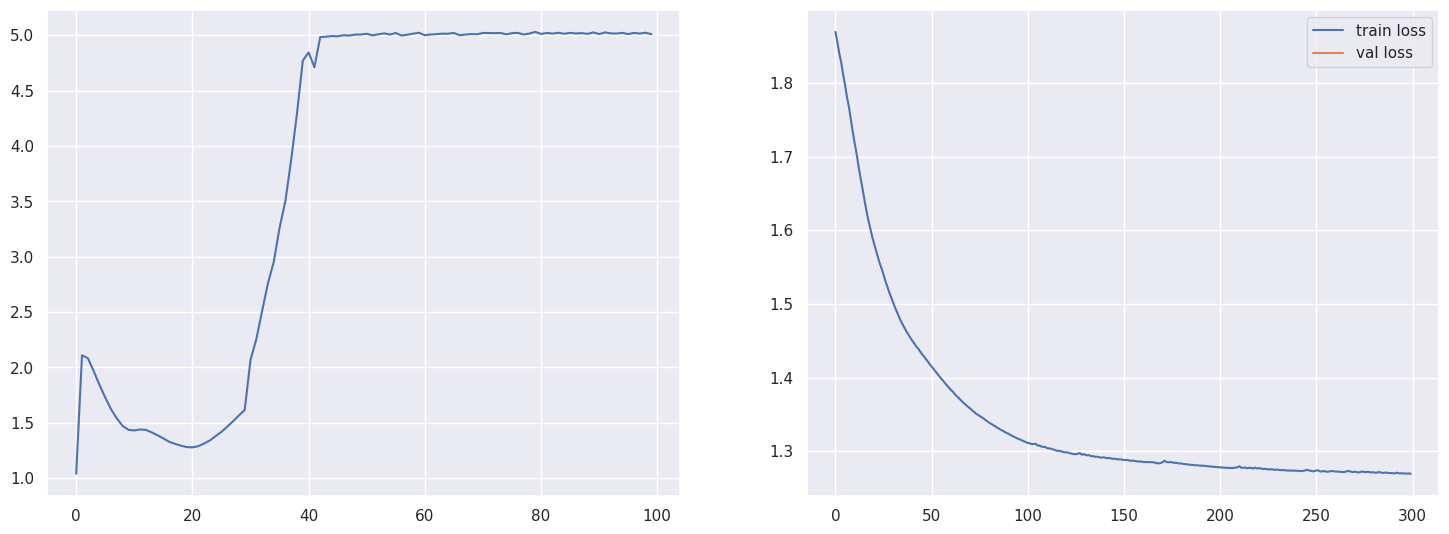

2
Final Training Loss: 1.181
Epoch: 299


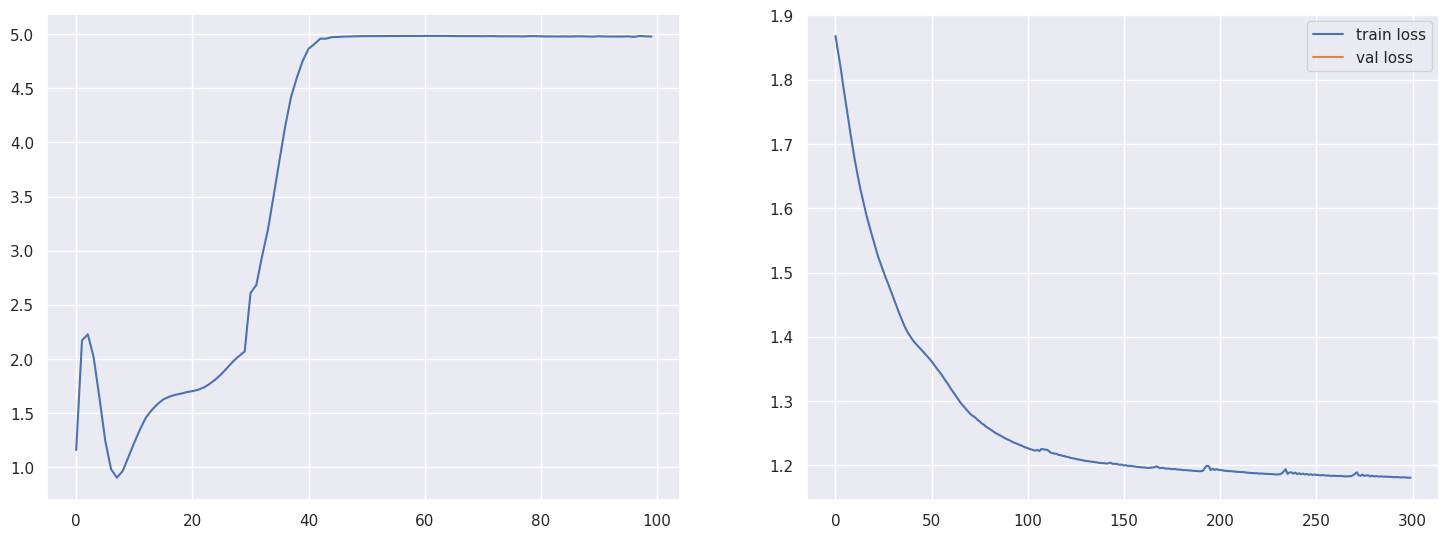

3
Final Training Loss: 1.180
Epoch: 299


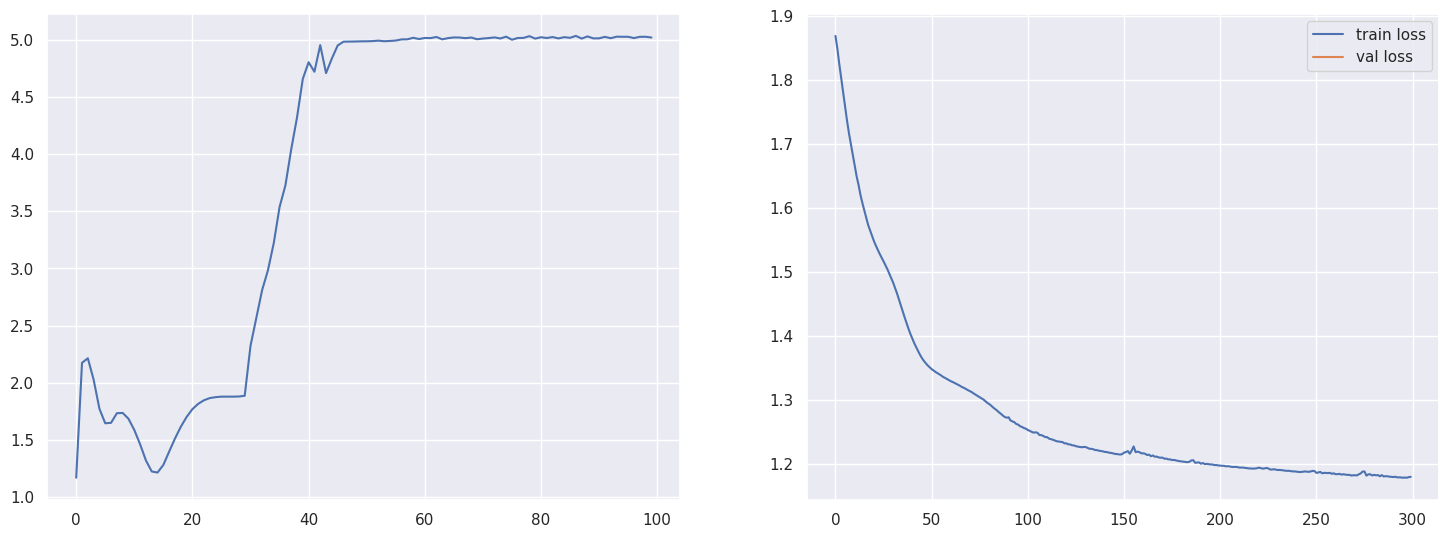

4
Final Training Loss: 1.262
Epoch: 299


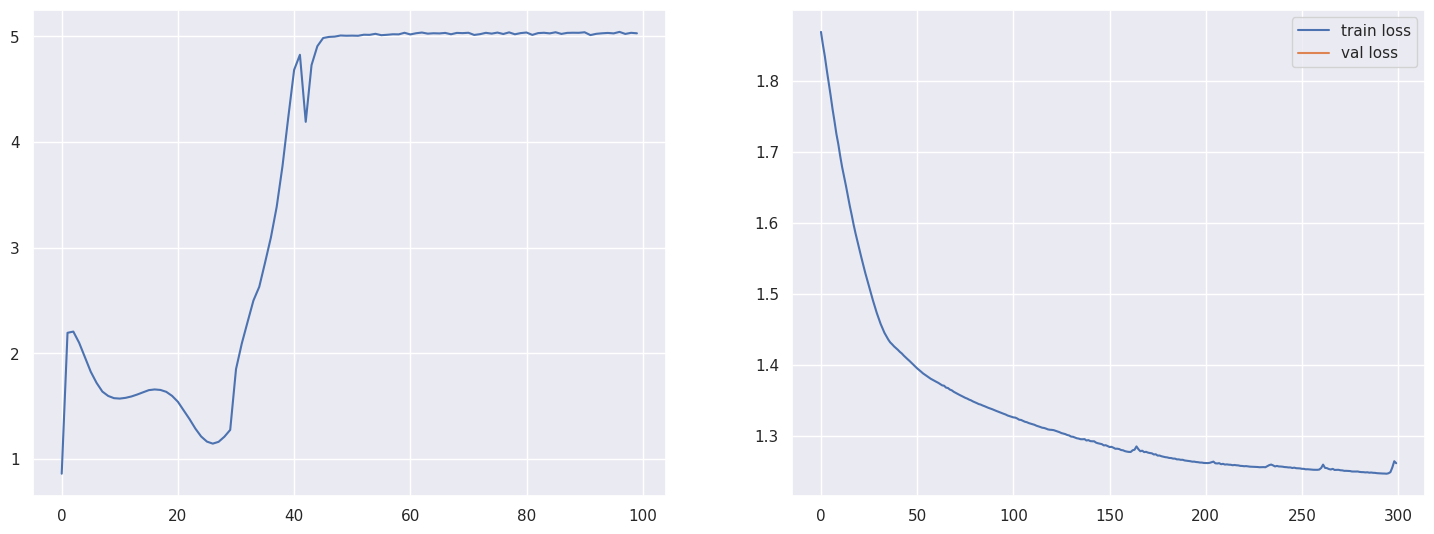

5
Final Training Loss: 1.289
Epoch: 299


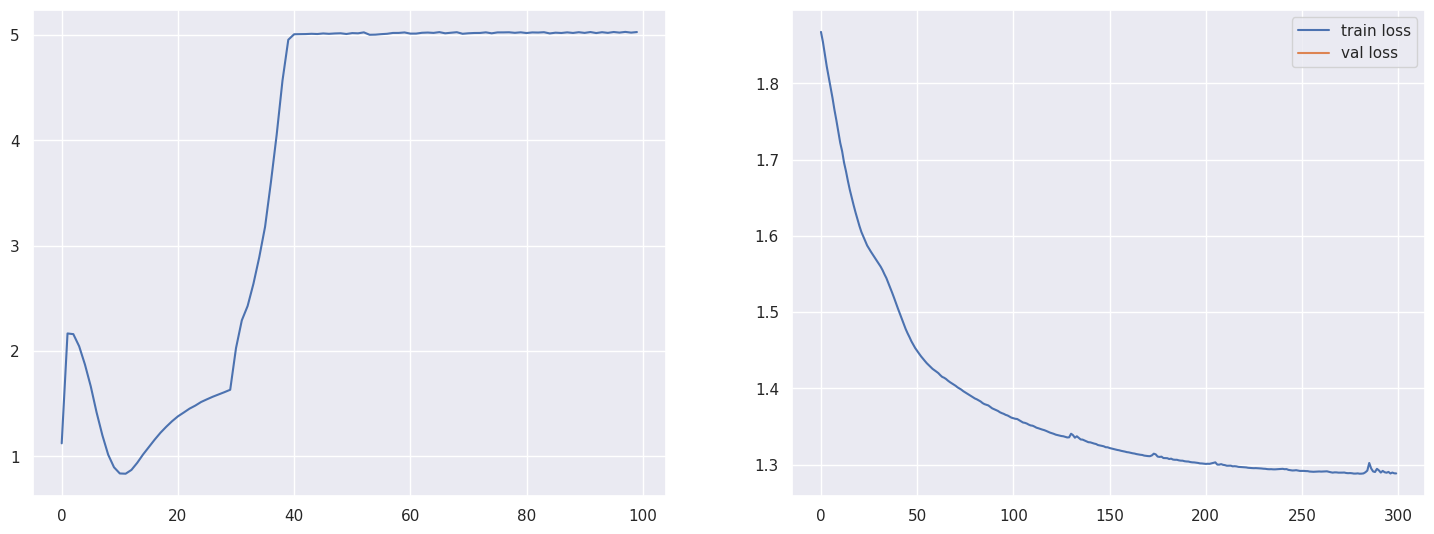

6
Final Training Loss: 1.200
Epoch: 299


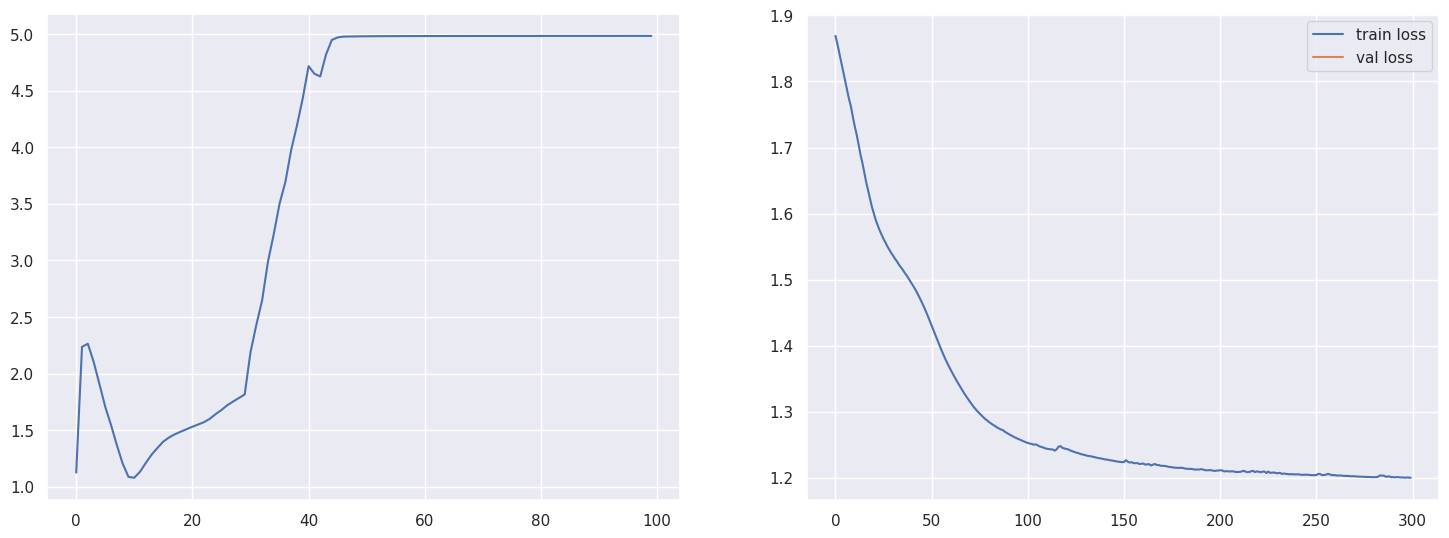

7
Final Training Loss: 1.165
Epoch: 299


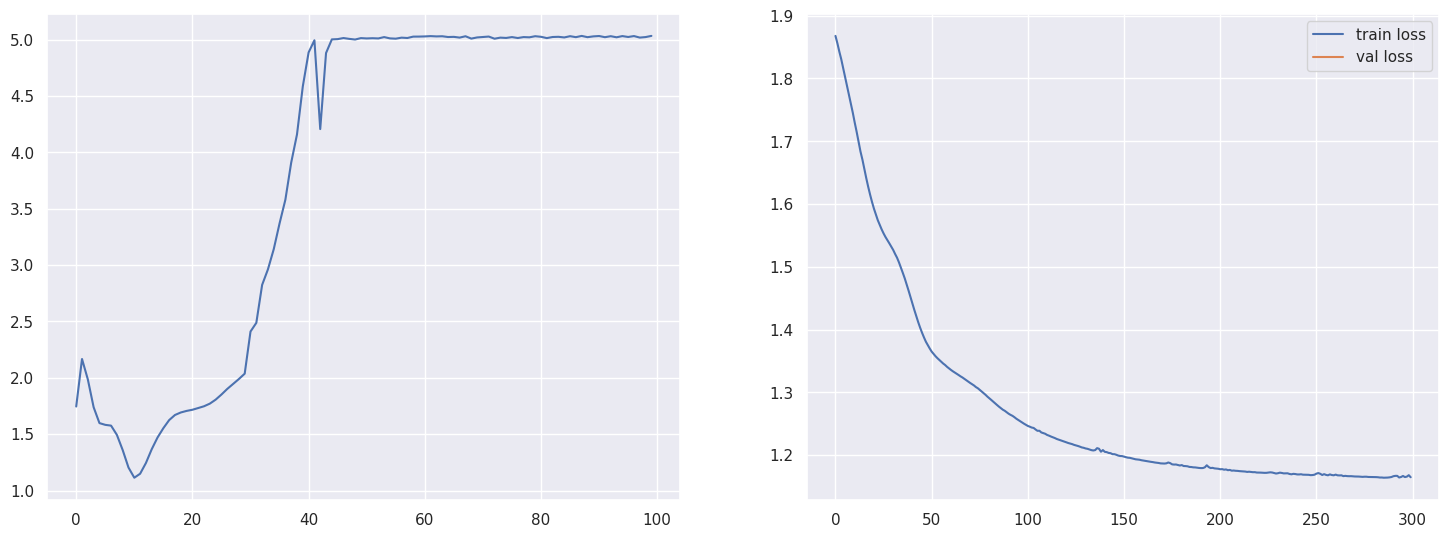

8
Final Training Loss: 1.252
Epoch: 299


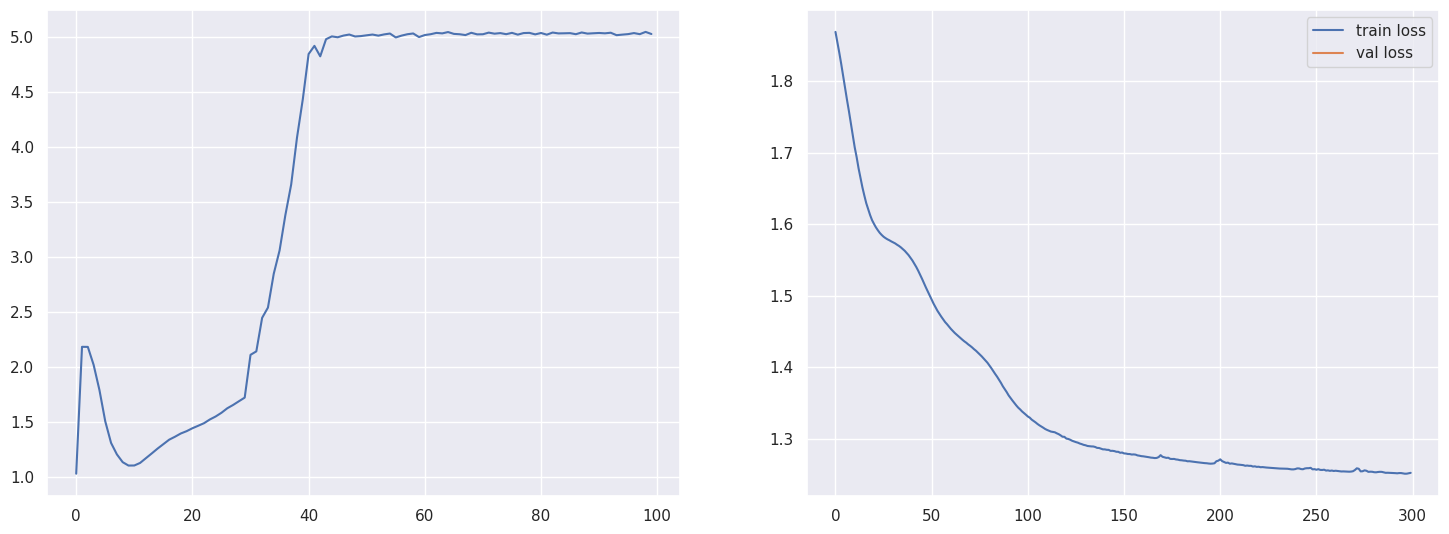

9
Final Training Loss: 1.255
Epoch: 299


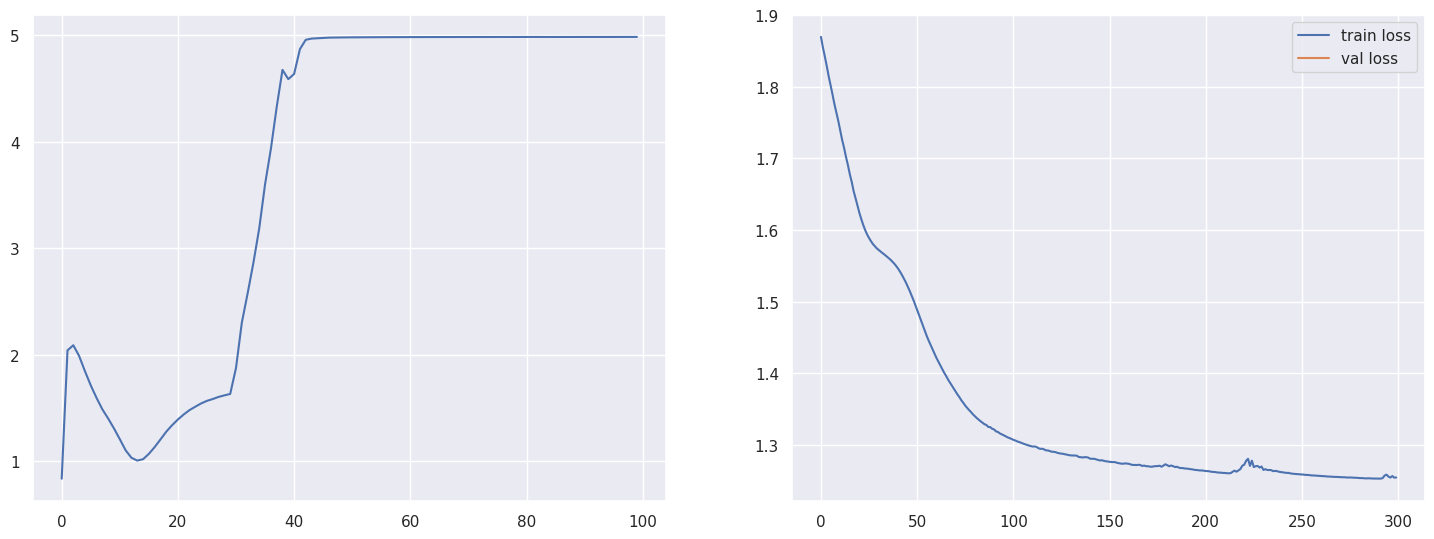

In [ ]:
epoch = list(range(T)) * 10
for cost_coef in [0.1, 0.05]:
    spg_cv = []
    init_seed = 0
    print(cost_coef)

    for rep_index in range(10):
        spg_curve = StrategicGD(cost_coef=cost_coef, lr_pi=0.1, lr_prob=0.02, seed=init_seed + rep_index, dim_v=dim_v, card_u=card_u, beta=beta, H=H, len_seq=len_seq, num_epoch=num_epoch, T=T, n=n, n_eval=n_eval)                
        spg_cv.extend(spg_curve)

    df = pd.DataFrame({'epoch': epoch, "spg": spg_cv})
    df.to_csv("result/GP_coef_{}.csv".format(cost_coef))